In [1]:
import gymnasium as gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Code implementations derived from https://github.com/mimoralea/gdrl and https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

# Value Function Approximation

- For simple environments, the value function is represented with a simple lookup table
- For environments with very large and/or continuous state and action spaces, tables may not be feasible
- In these cases, we must approximate the value function with a parameterized ($\theta$) function:
  - $\hat{v}(s ; \theta) \approx v_\pi(s)$
  - $\hat{q}(s, a ; \theta) \approx q_\pi(s,a)$

## Neural Fitted Q (NFQ) Iteration

- Approximates action-value ($Q$) function using a neural network
- A couple of considerations

### Value function to approximate

- State-value function $v(s)$
- Action-value function $q(s,a)$
- Action-advantage function $a(s,a)$

### Neural network architecture

- Input nodes
- Output nodes
- \# and size of hidden layers

- State-action-in-value-out architecture
  - State and action variable input nodes
  - Value output (ex: $Q(s,a)$) as single node
- State-in-values-out architecture
  - State variable input nodes
  - Vector of values for each action as output nodes

In [2]:
#Fully-connected neural network
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), #define hidden layers as tuple where each element is an int representing # of neurons at a layer
                 activation_fc=nn.ReLU):
        super(FCQ, self).__init__()

        hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            hidden_layers.append(activation_fc())
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *hidden_layers,
            nn.Linear(hidden_dims[-1], output_dim)
        )

        device = "cpu"
        #if torch.cuda.is_available():
        #    device = "cuda"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        return self.layers(x)
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    #load experience samples to device
    def load(self, experiences):
        states, actions, rewards, new_states, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, rewards, new_states, is_terminals

In [3]:
class OldFCQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32), 
                 activation_fc=F.relu):
        super(OldFCQ, self).__init__()
        self.activation_fc = activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            hidden_layer = nn.Linear(hidden_dims[i], hidden_dims[i+1])
            self.hidden_layers.append(hidden_layer)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)
        
    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        return x

    def forward(self, state):
        x = self._format(state)
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable
    
    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

### What to optimize

- Ideal objective would be to minimize loss with respect to the optimal action-value function $q^*$, with estimate $Q$
  - $$L_i(\theta_i) = \mathbb{E}_{s,a}[(q^*(s,a) - Q(s,a;\theta_i))^2]$$
- Problem: we don't have $q^*$, nor do we have the optimal policy $\pi^*$ to sample from $q^*$
- Solution: Use principles of genralized policy iteration (GPI), alternating between policy evaluation and policy improvement to find good policies
  - Convergence guarentees no longer exist for non-linear function approximation

### Targets for policy evaluation

- **Monte Carlo:** use all reward found in trajectory from start state to terminal state
- **Temporal Difference (TD(0)):** use value of next state as an estimate of future rewards (Bellman equation)
  - On-policy = SARSA
  - Off-policy (approximate using greedy) = Q-learning
- **N-step TD:** Like TD, but instead of bootstrapping after one step, use $n$ steps
- **TD($\lambda$):** Exponentially decaying n-step targets
- ***Notes on TD targets:***
  - Only backpropogate through the predicted values, not the target!
    - $$\nabla_{\theta_i}L_i(\theta_i) = \mathbb{E}_{s,a,r,s'}[(y_i - Q(s,a;\theta_i))\nabla_{\theta_i}Q(s,a;\theta_i)]$$
    - where $$y_i = r+\gamma\underset{a'}\max\;Q(s',a';\theta_i)$$
  - In supervised learning, the targets are constant *true* values
  - In RL, the TD target is not a *true* value; it is the reward (constant) plus the discounted value of the next state (comes from the model)
  - In forming the TD target, the predicted values of the next states need to be treated as a constant
    - In PyTorch, use *detach* method

### Optimization methods

- Gradient descent
  - Update parameters according to opposite direction of the gradient of the loss function
  - Stable under the assumption that data is independent and identically distributed (IID) and targets are stationary
  - Cannot guarentee those assumptions in RL
- Batch gradient descent
  - Uses the entire dataset to calculate loss and gradient
  - Steps towards gradient slowly at each step
  - Can be too slow to be practical
  - In RL, we do not have access to entire datasets in advance
- Mini-batch gradient descent
  - Uses fraction of data at a time (uniformly sampled mini-batch)
  - Noisier updates, but faster processing of data
  - ***Momentum*** variant updates weights using moving average of gradients instead of gradient at each step
- Stochastic gradient descent
  - Mini-batch gradient descent with batch size = 1
  - Calculate and move towards gradient of single sample at each step
- Root mean square propogation (RMSprop)
  - Scales gradient in proportion to average magnitude of recent gradients (square root of the moving average of the square of gradients)
- Adaptive momentum estimation (Adam)
  - Combination of RMSprop and momentum
  - Step in direction of moving average of gradients (momentum)
  - Step in proportion to average magnitude of recent gradients (RMSprop)

### **Overall concerns to address in RL:**
- Targets are not stationary because target values depend on the values for the next state, which we estimate using the neural network
- Samples are not IID when collected and processed online
  - Most of the samples in a mini-batch will come from the same trajectory and policy
  - Samples in mini-batches are internally correlated, but likely different from other mini-batches (different policies)

## Deep Q Network (DQN)

### Target networks

- Separate network that is fixed for multiple steps
  - Can also use *Polyak averaging* to smooth target network progression by mixing in a tiny bit of the online network at every step
    - $\theta_i^- = \tau\theta_i + (1-\tau)\theta_i^-$
- Used to calculate more stationary targets
- Helps improve chances of convergence, substantially reduces chance of divergence
- Target calculation with target network weights $\theta^-$: $$y_i = r+\gamma\underset{a'}\max\;Q(s',a';\theta^-)$$

### Experience replay

- A replay buffer/memory holds experience samples for **several** steps, over many episodes (if environment terminates)
- Mini-batches can then be uniformly sampled from a broad set of past experiences
- Updates to the network are better distributed and more representative of the true value function
- Agent can sample and train on every time step with a lower risk of divergence

In [4]:
class ReplayBuffer():
    def __init__(self, 
                 max_size=10000):
        #initialize fixed-length np arrays for each element of experience tuple (state, action, reward, next state, done)
        self.ss_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.as_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.rs_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ps_mem = np.empty(shape=(max_size), dtype=np.ndarray)
        self.ds_mem = np.empty(shape=(max_size), dtype=np.ndarray)

        self.max_size = max_size
        self._idx = 0 #where to add next sample
        self.size = 0
    
    def store(self, sample): #store sample into replay memory
        s, a, r, p, d = sample
        self.ss_mem[self._idx] = s
        self.as_mem[self._idx] = a
        self.rs_mem[self._idx] = r
        self.ps_mem[self._idx] = p
        self.ds_mem[self._idx] = d
        
        self._idx += 1
        self._idx = self._idx % self.max_size #replace older samples when at max capacity

        self.size += 1
        self.size = min(self.size, self.max_size)


    def sample(self, batch_size=1): #return batch of samples selected uniform randomly

        idxs = np.random.choice(
            self.size, batch_size, replace=False)
        
        experiences = np.vstack(self.ss_mem[idxs]), np.vstack(self.as_mem[idxs]), np.vstack(self.rs_mem[idxs]), np.vstack(self.ps_mem[idxs]), np.vstack(self.ds_mem[idxs])
        return experiences

    def __len__(self):
        return self.size

### Full DQN Implementation

In [5]:
class EGreedyExpStrategy():
    def __init__(self, init_epsilon=1.0, min_epsilon=0.1, decay_steps=20000):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_steps = decay_steps
        self.min_epsilon = min_epsilon
        self.epsilons = 0.01 / np.logspace(-2, 0, decay_steps, endpoint=False) - 0.01
        self.epsilons = self.epsilons * (init_epsilon - min_epsilon) + min_epsilon
        self.t = 0

    def select_action(self, model, state):
        self.exploratory_action_taken = False
        with torch.no_grad():
            if np.random.rand() > self.epsilon:
                action = model(state).detach().max(1).indices.view(1, 1).item() #choose action with highest estimated value
            else:
                action = np.random.randint(model(state).shape[1]) #random action

        self.epsilon = self.min_epsilon if self.t >= self.decay_steps else self.epsilons[self.t]
        self.t += 1
        
        return action

In [6]:
class DQN():
    def __init__(self, 
                value_model_fn = lambda num_obs, nA: FCQ(num_obs, nA), #state vars, nA -> model
                value_optimizer_fn = lambda params, lr : optim.RMSprop(params, lr), #model params, lr -> optimizer
                value_optimizer_lr = 1e-4, #optimizer learning rate
                loss_fn = nn.MSELoss(), #input, target -> loss
                exploration_strategy = EGreedyExpStrategy(), #module with select_action function (model, state) -> action
                memory_size = 10000 #replay memory capacity
                ):
        self.value_model_fn = value_model_fn
        self.value_optimizer_fn = value_optimizer_fn
        self.value_optimizer_lr = value_optimizer_lr
        self.loss_fn = loss_fn
        self.exploration_strategy = exploration_strategy
        self.memory = ReplayBuffer(memory_size)

    def _init_model(self, env):
        #initialize online and target models
        self.online_model = self.value_model_fn(len(env.observation_space.sample()), env.action_space.n)
        self.target_model = self.value_model_fn(len(env.observation_space.sample()), env.action_space.n)
        self.target_model.load_state_dict(self.online_model.state_dict()) #copy online model parameters to target model
        #initialize optimizer
        self.optimizer = self.value_optimizer_fn(self.online_model.parameters(), lr=self.value_optimizer_lr)
    
    def _optimize_model(self):
        experiences = self.memory.sample(self.batch_size)
        experiences = self.online_model.load(experiences)
        states, actions, rewards, next_states, is_terminals = experiences
    
        max_a_q_sp = self.target_model(next_states).detach().max(1)[0].unsqueeze(1) #values for next states
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals)) #calculate q target

        q_sa = self.online_model(states).gather(1, actions) #get predicted q from model for each state, action pair

        loss = self.loss_fn(q_sa, target_q_sa) #calculate loss between prediction and target

        #optimize step (gradient descent)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def train(self, env, gamma=1.0, num_episodes=100, batch_size=64, n_warmup_batches = 5, tau=0.005, target_update_steps=1, save_models=None):
        if save_models: #list of episodes to save models
                save_models.sort()
        self.gamma = gamma
        self.batch_size = batch_size
        self._init_model(env)

        saved_models = {}
        best_model = None

        i = 0
        episode_returns = np.zeros(num_episodes)
        for episode in range(num_episodes):
            state = env.reset()[0]
            ep_return = 0
            for t in count():
                i += 1
                action = self.exploration_strategy.select_action(self.online_model, state) #use online model to select action
                next_state, reward, terminated, truncated, _ = env.step(action)
                self.memory.store((state, action, reward, next_state, terminated)) #store experience in replay memory
                
                state = next_state

                if len(self.memory) >= batch_size*n_warmup_batches: #optimize policy model
                    self._optimize_model()

                #update target network with tau
                if i % target_update_steps == 0:
                    #self.target_model.load_state_dict(self.online_model.state_dict())
                    for target, online in zip(self.target_model.parameters(), self.online_model.parameters()):
                        target_weights = tau*online.data + (1-tau)*target.data
                        target.data.copy_(target_weights)

                ep_return += reward * gamma**t #add discounted reward to return
                if terminated or truncated:
                    #save best model
                    if ep_return >= episode_returns.max():
                        copy = self.value_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.online_model.state_dict())
                        best_model = copy
                    #copy and save model
                    if save_models and len(saved_models) < len(save_models) and episode+1 == save_models[len(saved_models)]:
                        copy = self.value_model_fn(len(env.observation_space.sample()), env.action_space.n)
                        copy.load_state_dict(self.online_model.state_dict())
                        saved_models[episode+1] = copy

                    episode_returns[episode] = ep_return
                    break
        
        return episode_returns, best_model, saved_models



### Double DQN

- Traditional DQN often overestimates action-value functions due to *maximization bias*
  - Performance suffers from positive bias as estimated values are often off-center
- Double DQN is a practical improvement that does not drastically increase overhead
- Select best action of next state using online network, but still use target network for target value estimates
  - DQN target: $$y_i = r+\gamma\underset{a'}\max\;Q(s',a';\theta^-)$$ $$y_i = r+\gamma Q(s',\underset{a'}{\mathrm{argmax}}\;Q(s',a';\theta^-);\theta^-)$$
  - DDQN target: $$y_i = r+\gamma Q(s',\underset{a'}{\mathrm{argmax}}\;Q(s',a';\theta_i);\theta^-)$$

In [7]:
#DDQN implements one small change to DQN
class DDQN(DQN):
    #only need to change the optimize model method, everything else is inherited from DQN
    def _optimize_model(self):
        experiences = self.memory.sample(self.batch_size)
        experiences = self.online_model.load(experiences)
        states, actions, rewards, next_states, is_terminals = experiences
    
        argmax_a_q_sp = self.online_model(next_states).max(1)[1] #select best action of next state according to online model
        max_a_q_sp = self.target_model(next_states).detach()[np.arange(self.batch_size), argmax_a_q_sp].unsqueeze(1) #get values of next states using target network
        target_q_sa = rewards + (self.gamma * max_a_q_sp * (1 - is_terminals)) #calculate q target

        q_sa = self.online_model(states).gather(1, actions) #get predicted q from model for each state, action pair

        loss = self.loss_fn(q_sa, target_q_sa) #calculate loss between prediction and target

        #optimize step (gradient descent)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

### Dueling DDQN

- The action advantage function is the difference in expected return when selecting action $a$ at state $s$ over following policy $\pi$: $a_\pi(s,a)=q_\pi(s,a)-v_\pi(s)$
- We can rearrange this formula to see how the state-value function $v$ relates to the action-value function $q$: $q_\pi(s,a)=v_\pi(s,a)+a_\pi(s)$
- We can decompose a $Q$ function into two components:
  - one that is independent on the action: $V(s)$
  - one that is dependent on the action $A(s,a)$
- Network architecture can be made to take advantage of this decomposition
  - Network splits into two streams: a stream for the state-value function $V(s)$, and another for the action-advantage function $A(s,a)$
  - $V(s)$ is represented as a single node; $A(s,a)$ should have a node for each action in the action space
  - Final output layer should represent $Q(s,a)$ with a node for each action
    - All output nodes are connected to $V(s)$ node
    - For each action, output node connects to its corresponding $A(s,a)$ node
- The action-value function, $Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + A(s,a;\theta,\alpha)$ is now parameterized by three sets of weights
  - $\theta$ - weights of the shared layers
  - $\alpha$ - weights of the action-advantage function stream
  - $\beta$ - weights of the state-value function stream
- **Problem:** hard to discriminate between $V$ and $A$ from $Q$ using simple $Q=V+A$ function, in practice we subtract the mean of the advantages:
  - $$Q(s,a;\theta,\alpha,\beta) = V(s;\theta,\beta) + \left(A(s,a;\theta,\alpha)-\frac{1}{|A|}\sum_{a'}A(s,a';\theta,\alpha)\right)$$

In [8]:
class FCDuelingQ(nn.Module):
    def __init__(self, 
                 input_dim, 
                 output_dim, 
                 hidden_dims=(32,32),
                 v_hidden_dims = (32,),
                 a_hidden_dims = (32,),
                 activation_fc=nn.ReLU):
        super(FCDuelingQ, self).__init__()
        
        #build hidden layers for features, value stream, and advantage stream
        feature_hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            feature_hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            feature_hidden_layers.append(activation_fc())

        v_hidden_layers = nn.ModuleList()
        for i in range(len(v_hidden_dims)-1):
            v_hidden_layers.append(nn.Linear(v_hidden_dims[i], v_hidden_dims[i+1]))
            v_hidden_layers.append(activation_fc())

        a_hidden_layers = nn.ModuleList()
        for i in range(len(a_hidden_dims)-1):
            a_hidden_layers.append(nn.Linear(a_hidden_dims[i], a_hidden_dims[i+1]))
            a_hidden_layers.append(activation_fc())

        #build features, value stream, and advantage stream
        self.features = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            activation_fc(),
            *feature_hidden_layers
        )

        self.value_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], v_hidden_dims[0]),
            activation_fc(),
            *v_hidden_layers,
            nn.Linear(v_hidden_dims[-1], 1)
        )

        self.advantage_stream = nn.Sequential(
            nn.Linear(hidden_dims[-1], a_hidden_dims[0]),
            activation_fc(),
            *a_hidden_layers,
            nn.Linear(a_hidden_dims[-1], output_dim)
        )

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
        self.device = torch.device(device)
        self.to(self.device)

    def _format(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             device=self.device, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)      
        return x

    def forward(self, state):
        x = self._format(state)
        features = self.features(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qs = values + (advantages - advantages.mean())
        return qs
    
    def numpy_float_to_device(self, variable):
        variable = torch.from_numpy(variable).float().to(self.device)
        return variable

    def load(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals


# Demos

In [12]:
def run_model(env, model, gamma=1, num_episodes=1):
    ep_returns = []
    for _ in range(num_episodes):
        ep_return = 0
        state = env.reset()[0]
        for t in count():
            action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward * gamma**t
            state = next_state
            if terminated or truncated:
                ep_returns.append(ep_return)
                break
    return ep_returns

In [13]:
def train_dqn(dqn, **kwargs):
    env = gym.make('CartPole-v1')
    return dqn.train(env, **kwargs)

In [11]:
dqn = DQN(value_model_fn = lambda num_obs, nA: FCQ(num_obs, nA, hidden_dims=(512, 128,)),
          value_optimizer_lr = 0.0001,
          exploration_strategy=EGreedyExpStrategy(min_epsilon=0.01),
          memory_size=50000,
          )

ddqn = DDQN(value_model_fn = lambda num_obs, nA: FCQ(num_obs, nA, hidden_dims=(512, 128,)),
          value_optimizer_lr = 0.0001,
          exploration_strategy=EGreedyExpStrategy(min_epsilon=0.01),
          memory_size=50000,
          )

dueling_ddqn = DDQN(value_model_fn = lambda num_obs, nA: FCDuelingQ(num_obs, nA, hidden_dims=(512,)),
          value_optimizer_lr = 0.0001,
          exploration_strategy=EGreedyExpStrategy(min_epsilon=0.01),
          memory_size=50000,
          )

In [16]:
dqns = {'dqn' : dqn, 'ddqn' : ddqn, 'dueling_ddqn' : dueling_ddqn}
dqn_results = {}
for name, method in dqns.items():
    print('Testing ' + name +'...')
    dqn_results[name] = train_dqn(method, num_episodes=800, tau=0.01, batch_size=128, save_models=[1, 100, 250, 500, 800])

print('Saving results...')
import pickle
with open('dqn.tests', 'wb') as file:
    pickle.dump(dqn_results, file)

Testing dqn...
Testing ddqn...
Testing dueling_ddqn...
Saving results...


### Results

In [9]:
import pickle
res = {}
with open('dqn.tests', 'rb') as file:
    res = pickle.load(file)

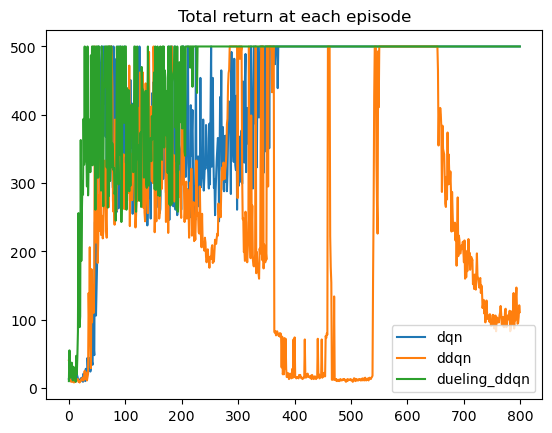

In [10]:
plt.title('Total return at each episode')
for test in res:
    episode_returns = res[test][0]
    plt.plot(range(len(episode_returns)), episode_returns, label=test)
plt.legend()

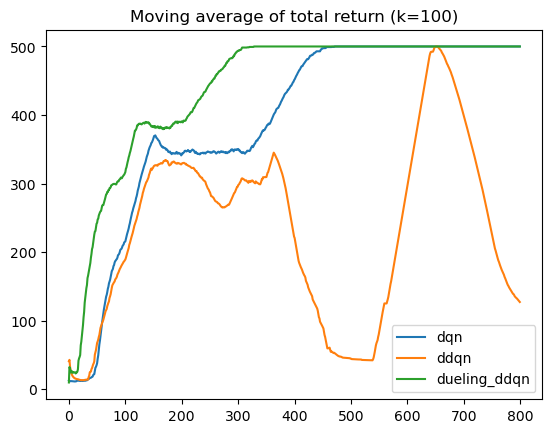

In [11]:
plt.title('Moving average of total return (k=100)')
for test in res:
    episode_returns = res[test][0]
    plt.plot(range(len(episode_returns)), [np.mean(episode_returns[max(0,x-100):x+1]) for x in range(len(episode_returns))], label=test)

plt.legend()

In [51]:
import pygame
pygame.init()
font = pygame.font.SysFont('Comic Sans MS', 16)
env = gym.make('CartPole-v1', render_mode='human')
env.metadata['render_fps']=0
STEPS = 1000
env.reset()[0]
for method in res:
    text = font.render(method, False, (0, 0, 0))
    for i, model in res[method][2].items():
        state = env.reset()[0]
        ep_return = 0
        return_sum = 0
        episode = 1
        for x in range(STEPS):
            action = model(state).detach().max(1).indices.view(1, 1).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_return += reward
            if terminated or truncated:
                state = env.reset()[0]
                return_sum += ep_return
                ep_return = 0
                episode += 1
            else:
                state = next_state
            
            text = font.render(f'{method} model at episode {i}', False, (0, 0, 0))
            progress_text = font.render(f'{x}/{STEPS}', False, (0, 0, 0))
            return_text = font.render(f'Current return at episode {episode}: {ep_return}', False, (0, 0, 0))
            env.screen.blit(text, (10, 10))
            env.screen.blit(progress_text, (10, 42))
            env.screen.blit(return_text, (10, 74))
            if return_sum:
                mean_return_text = font.render(f'Mean return: {np.round(return_sum/(episode-1),3)}', False, (0, 0, 0))
                env.screen.blit(mean_return_text, (10, 106))
            pygame.event.pump()
            pygame.display.update()
            env.clock.tick(0)

In [14]:
dueling_ddqn = DDQN(value_model_fn = lambda num_obs, nA: FCDuelingQ(num_obs, nA, hidden_dims=(512,)),
          value_optimizer_lr = 0.0001,
          exploration_strategy=EGreedyExpStrategy(min_epsilon=0.01),
          memory_size=50000,
          )

In [15]:
_, _, save_models = train_dqn(dueling_ddqn, num_episodes=500, tau=0.01, batch_size=128, save_models=[1, 10, 50, 100, 250, 500])

In [16]:
import pickle
with open('dqdn.models', 'wb') as file:
    pickle.dump(save_models, file)

In [17]:
save_models = []
with open('dqdn.models', 'rb') as file:
    save_models = pickle.load(file)

In [25]:
import pygame
pygame.init()
font = pygame.font.SysFont('Comic Sans MS', 16)
env = gym.make('CartPole-v1', render_mode='human')
env.metadata['render_fps']=120
STEPS = 500
env.reset()[0]
for i, model in save_models.items():
    state = env.reset()[0]
    ep_return = 0
    return_sum = 0
    episode = 1
    for x in range(STEPS):
        action = model(state).detach().max(1).indices.view(1, 1).item()
        next_state, reward, terminated, truncated, _ = env.step(action)
        ep_return += reward
        if terminated or truncated:
            state = env.reset()[0]
            return_sum += ep_return
            ep_return = 0
            episode += 1
        else:
            state = next_state
        
        text = font.render(f'Dueling DDQN model at episode {i}', False, (0, 0, 0))
        progress_text = font.render(f'{x}/{STEPS}', False, (0, 0, 0))
        return_text = font.render(f'Current return at episode {episode}: {ep_return}', False, (0, 0, 0))
        env.screen.blit(text, (10, 10))
        env.screen.blit(progress_text, (10, 42))
        env.screen.blit(return_text, (10, 74))
        if return_sum:
            mean_return_text = font.render(f'Mean return: {np.round(return_sum/(episode-1),3)}', False, (0, 0, 0))
            env.screen.blit(mean_return_text, (10, 106))
        pygame.event.pump()
        pygame.display.update()
        env.clock.tick(0)

In [26]:
env.close()